In [1]:
# user review to movies [network analysis]

# tf-idf predict

# CNN 用情感分析代码

# process data
import pandas as pd 
import numpy as np
import re

# deal with file path
import os
from os.path import join

# plot
import seaborn as sns
import matplotlib.pyplot as plt

# processing bar
import tqdm

In [2]:
# read imdb movie review data
imdb_df = pd.read_csv(join('F:\\OSA_data', 'imdb_review.csv'))
imdb_df.head()

,movieId,reviewDate,userId,userReview
0,111161,24 July 2010,16161013,"[<div class=""text show-more__control clickable..."
1,111161,26 November 2003,2509775,"[<div class=""text show-more__control clickable..."
2,111161,21 November 2005,265899,"[<div class=""text show-more__control clickable..."
3,111161,18 February 2008,16117882,"[<div class=""text show-more__control clickable..."
4,111161,8 February 2001,1005460,"[<div class=""text show-more__control"">I have n..."


In [3]:
# clean review string
cleaned_review = list(imdb_df['userReview'])
for i, s in enumerate(cleaned_review):
    cleaned_review[i] = re.sub("<.*?>", "", s)
    cleaned_review[i] =cleaned_review[i].replace('[', '').replace(']', '')

imdb_df['review'] = cleaned_review
imdb_df = imdb_df.drop(labels='userReview',axis=1) 
imdb_df.head()

,movieId,reviewDate,userId,review
0,111161,24 July 2010,16161013,The Shawshank Redemption is written and direct...
1,111161,26 November 2003,2509775,Why do I want to write the 234th comment on Th...
2,111161,21 November 2005,265899,I'm trying to save you money; this is the last...
3,111161,18 February 2008,16117882,This movie is not your ordinary Hollywood flic...
4,111161,8 February 2001,1005460,I have never seen such an amazing film since I...


In [4]:
# The number of the users is quiet large, which will make the time of network plot very long, so I just choose some active users
from collections import Counter
user_count = Counter(imdb_df['userId'])
print(user_count)

Counter({4445210: 97, 453068: 89, 1002035: 85, 3270789: 81, 20552756: 80, 2488512: 72, 2467618: 68, 4103165: 62, 2898520: 53, 4532636: 51, 4888011: 50, 16161013: 49, 2483625: 49, 643062: 45, 118977607: 44, 87850731: 42, 2860723: 42, 20018357: 41, 1173088: 40, 114649661: 40, 45390749: 39, 1416505: 38, 989035: 38, 114712021: 37, 688559: 36, 278527: 36, 30163554: 34, 1234929: 33, 463200: 33, 1174211: 33, 114692853: 33, 4405474: 31, 1532177: 30, 391152: 30, 4234119: 29, 1048771: 29, 1293485: 28, 2420383: 28, 65733095: 28, 89494061: 27, 2590596: 27, 94289145: 27, 50463365: 27, 41485753: 27, 3063013: 26, 20961309: 26, 13134536: 26, 2375356: 26, 26820801: 26, 2339662: 25, 1098460: 25, 2093818: 24, 3872142: 24, 66111139: 24, 342623: 24, 15148330: 23, 2171244: 23, 6201371: 23, 18970655: 22, 15794099: 22, 32097297: 21, 8625456: 21, 381265: 21, 61859192: 20, 64212521: 20, 67902729: 20, 56005872: 20, 5156288: 19, 5788055: 19, 13566917: 19, 35229: 18, 82462880: 18, 10334028: 18, 1355003: 18, 122113

In [5]:
# # to reduce the nodes, I choose the top 50 movies

# movie_list = list(imdb_df['movieId'])
# movie_order = list(set(movie_list))
# movie_order.sort(key=movie_list.index)

# top_movie_list = movie_order[:50]

In [6]:
active_user_list = [k for k, v in user_count.items() if v>=3]
print(len(active_user_list))

1034


In [7]:
imdb_df = imdb_df[imdb_df.userId.isin(active_user_list)]
imdb_df

,movieId,reviewDate,userId,review
0,111161,24 July 2010,16161013,The Shawshank Redemption is written and direct...
3,111161,18 February 2008,16117882,This movie is not your ordinary Hollywood flic...
7,111161,13 July 1999,355122,Misery and Stand By Me were the best adaptatio...
8,111161,25 March 1999,257957,One of the finest films made in recent years. ...
10,111161,23 February 2020,87850731,The Shawshank Redemption has great performance...
...,...,...,...,...
24896,2991224,19 January 2020,98906416,Leisurely and very dry microcosm of war where ...
24897,2991224,1 July 2019,104603847,Nice movie with a nice story. mostly talking b...
24898,2991224,30 December 2018,39634854,A well-worn message on the frivolity of war wh...
24901,2991224,10 October 2020,41485753,This film was spectacular. A war movie about t...


## Network of user commenting on movies

In [8]:
# Fistly, check whether there exists an overlap between movieId and userId

movie_id = set(imdb_df['movieId'])
print(len(movie_id))

user_id = set(imdb_df['userId'])
print(len(user_id))

print(len(movie_id & user_id))

250
1034
0


In [9]:
# Then, link the user and the movie he or she commented on
comment_pairs = list(zip(imdb_df['userId'], imdb_df['movieId']))

In [10]:
# build the network
import networkx as nx

def summary(graph):
    l = nx.info(graph).split('\n')
    for s in l:
        print(s)

review_graph = nx.Graph(name="Review Ggraph") 

review_graph.add_nodes_from(movie_id, type='movie')
review_graph.add_nodes_from(user_id, type='user')

review_graph.add_edges_from(comment_pairs)

summary(review_graph)

Name: Review Ggraph
Type: Graph
Number of nodes: 1284
Number of edges: 7763
Average degree:  12.0919


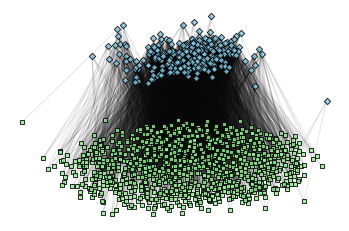

In [11]:
pos=nx.spring_layout(review_graph)

# Uncomment this for loop to separate the nodes: 
for node_id in movie_id:
    layout = pos[node_id]
    pos[node_id] = np.array([layout[0],(layout[1]+2)])

nx.draw_networkx_nodes(review_graph,pos,movie_id,node_color="skyblue",node_shape="D",node_size=20,alpha=.8,edgecolors="black")
nx.draw_networkx_nodes(review_graph,pos,active_user_list,node_color="lightgreen",node_shape="s",node_size=10,alpha=.8,edgecolors="black")
nx.draw_networkx_edges(review_graph,pos,alpha=.1)
plt.axis('off')

plt.savefig("movie_user.pdf", format="pdf")
plt.show()

In [12]:
user_movies = {}
movie_users = {}
for u_m in comment_pairs:
    if not user_movies.__contains__(u_m[0]):
        user_movies[u_m[0]]=[]
    user_movies[u_m[0]].append(u_m[1])
    
    if not movie_users.__contains__(u_m[1]):
        movie_users[u_m[1]]=[]
    movie_users[u_m[1]].append(u_m[0])
 
user_user = []
movie_movie = []

for k, v in movie_users.items():
    for u1 in v:
        for u2 in v:
            if u1 != u2:
                user_user.append((u1,u2))
                
for k, v in user_movies.items():
    for m1 in v:
        for m2 in v:
            if m1 != m2:
                movie_movie.append((m1,m2))
        

In [13]:
user_graph = nx.Graph(name="User Ggraph") 

user_graph.add_nodes_from(user_id, type='user')

user_graph.add_edges_from(user_user)

summary(user_graph)

Name: User Ggraph
Type: Graph
Number of nodes: 1034
Number of edges: 92486
Average degree: 178.8897


In [14]:
movie_graph = nx.Graph(name="Movie Ggraph") 

movie_graph.add_nodes_from(movie_id, type='movie')

movie_graph.add_edges_from(movie_movie)

summary(movie_graph)

Name: Movie Ggraph
Type: Graph
Number of nodes: 250
Number of edges: 23933
Average degree: 191.4640


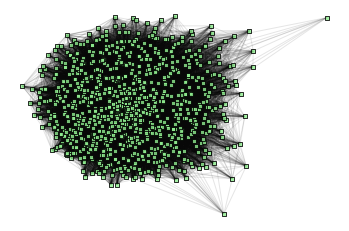

In [15]:
pos=nx.spring_layout(user_graph)

nx.draw_networkx_nodes(user_graph,pos,node_color="lightgreen",node_shape="s",node_size=10,alpha=.8,edgecolors="black")
nx.draw_networkx_edges(user_graph,pos,alpha=.1)
plt.axis('off')

plt.savefig("user.pdf", format="pdf")
plt.show()



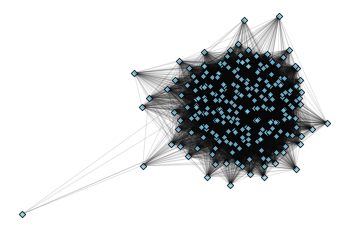

In [16]:
pos=nx.spring_layout(movie_graph)

nx.draw_networkx_nodes(movie_graph,pos,movie_id,node_color="skyblue",node_shape="D",node_size=20,alpha=.8,edgecolors="black")
nx.draw_networkx_edges(movie_graph,pos,alpha=.1)
plt.axis('off')

plt.savefig("movie.pdf", format="pdf")
plt.show()

0.13348754244807973


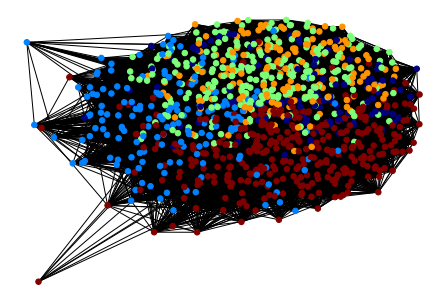

In [17]:
import community

part = community.best_partition(user_graph)
mod = community.modularity(part,user_graph)
print(mod)

values = [part.get(node) for node in user_graph.nodes()]
nx.draw_spring(user_graph, cmap=plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)
plt.savefig("user_community.pdf", format="pdf")
plt.show()

0.04248970076631556


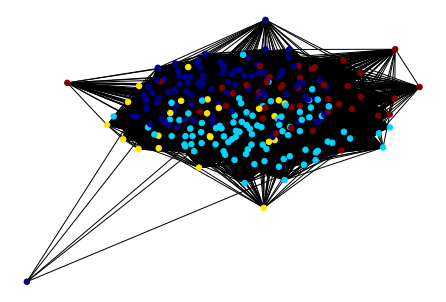

In [18]:
part = community.best_partition(movie_graph)
mod = community.modularity(part,movie_graph)
print(mod)

values = [part.get(node) for node in movie_graph.nodes()]
nx.draw_spring(movie_graph, cmap=plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)
plt.savefig("movie_community.pdf", format="pdf")
plt.show()

## Predict movie genres

In [19]:
# read imdb movie review data
imdb_all = pd.read_csv(join('F:\\OSA_data', 'imdb_movie_all.csv'))
imdb_all

,Name,Year,Rate,Level,Directors,Writers,Stars,Genres,Runtime,Country,Language,Budget,Box_Office_USA,Box_Office_World
0,The Shawshank Redemption,1994,9.3,IIB,Frank Darabont,Stephen King/Frank Darabont,Tim Robbins/Morgan Freeman/Bob Gunton/See full...,Drama,142 min,USA,English,"$25,000,000","$28,699,976","$28,817,291"
1,The Godfather,1972,9.2,IIB,Francis Ford Coppola,Mario Puzo/Francis Ford Coppola/1 more credit,Marlon Brando/Al Pacino/James Caan/See full ca...,Crime/Drama,175 min,USA,English/Italian/Latin,"$6,000,000","$134,966,411","$246,120,986"
2,The Godfather: Part II,1974,9.0,IIB,Francis Ford Coppola,Francis Ford Coppola/Mario Puzo/1 more credit,Al Pacino/Robert De Niro/Robert Duvall/See ful...,Crime/Drama,202 min,USA,English/Italian/Spanish/Latin/Sicilian,"$13,000,000","$47,834,595","$48,035,783"
3,The Dark Knight,2008,9.0,IIB,Christopher Nolan,Jonathan Nolan/Christopher Nolan/3 more credits,Christian Bale/Heath Ledger/Aaron Eckhart/See ...,Action/Crime/Drama/Thriller,152 min,USA/UK,English/Mandarin,"$185,000,000","$534,858,444","$1,005,973,645"
4,12 Angry Men,1957,9.0,I,Sidney Lumet,Reginald Rose/Reginald Rose,Henry Fonda/Lee J. Cobb/Martin Balsam/See full...,Crime/Drama,96 min,USA,English,"$350,000",NaN,$955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,Contratiempo,2016,8.1,IIA,Oriol Paulo,Oriol Paulo,Mario Casas/Ana Wagener/Jose Coronado/See full...,Crime/Drama/Mystery/Thriller,106 min,Spain,Spanish,"EUR4,000,000",NaN,"$31,191,910"
246,Koe no katachi,2016,8.1,IIA,Naoko Yamada,Yoshitoki Oima/Reiko Yoshida/1 more credit,Miyu Irino/Saori Hayami/Aoi Yûki/See full cast...,Animation/Drama/Family/Romance,130 min,Japan,Japanese/Japanese Sign Language,NaN,"$644,391","$30,490,447"
247,La battaglia di Algeri,1966,8.1,NaN,Gillo Pontecorvo,Franco Solinas/Franco Solinas/1 more credit,Brahim Hadjadj/Jean Martin/Yacef Saadi/See ful...,Drama/War,121 min,Italy/Algeria,Arabic/French/English,"$800,000","$879,794","$964,028"
248,Miracle in cell NO.7,2019,8.2,NaN,Mehmet Ada Öztekin,Özge Efendioglu/Kubilay Tat,Aras Bulut Iynemli/Nisa Sofiya Aksongur/Deniz ...,Drama,132 min,Turkey,Turkish,NaN,NaN,"$17,163,660"


In [20]:
# movie_genres = {}

# for i, name in enumerate(imdb_all['Name']):
#     if movie_genres.__contains__(name):
#         name += '(2)'
#         imdb_all['Name'][i] = name 

In [21]:
movie_list = list(imdb_df['movieId'])
movie_order = list(set(movie_list))
movie_order.sort(key=movie_list.index)

In [22]:
id_movie = dict(zip(movie_order, imdb_all['Name']))
id_genres = dict(zip(movie_order, imdb_all['Genres']))

In [23]:
from collections import OrderedDict

imdb_review = imdb_all[['Name', 'Genres']]

movie_review = OrderedDict()

for index, row in imdb_df.iterrows():
    name = id_movie[row['movieId']]
    if not movie_review.__contains__(name):
        movie_review[name] = ''
    movie_review[name] += ' ' + row['review']

imdb_review['review_sum'] = list(movie_review.values())
imdb_review

<ipython-input-23-db0de8d5a929>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_review['review_sum'] = list(movie_review.values())


,Name,Genres,review_sum
0,The Shawshank Redemption,Drama,The Shawshank Redemption is written and direc...
1,The Godfather,Crime/Drama,This isn't just a beautifully crafted gangste...
2,The Godfather: Part II,Crime/Drama,Michael is now established as the GODFATHER o...
3,The Dark Knight,Action/Crime/Drama/Thriller,"Confidently directed, dark, brooding, and pac..."
4,12 Angry Men,Crime/Drama,This once-in-a-generation masterpiece simply ...
...,...,...,...
245,Contratiempo,Crime/Drama/Mystery/Thriller,"Again, a successful example of a Spanish thri..."
246,Koe no katachi,Animation/Drama/Family/Romance,A Silent Voice is an anime drama film directe...
247,La battaglia di Algeri,Drama/War,I wish I could locate a videocassette of this...
248,Miracle in cell NO.7,Drama,Its shows the good in bad side of humanity in...


In [24]:
# random split train and test sets 8:2
import random

random.seed(37)

all_indices = range(0,250)
train_indices = random.sample(all_indices, 200)
train_names = imdb_review['Name'].iloc[train_indices]

train_names

174    The Bridge on the River Kwai
155          No Country for Old Men
23            It's a Wonderful Life
239                Fa yeung nin wah
158                The Elephant Man
                   ...             
173                  Salinui chueok
136                   All About Eve
83                          Amadeus
20                  La vita è bella
198              To Be or Not to Be
Name: Name, Length: 200, dtype: object

In [25]:
test_indices = [i for i in all_indices if i not in train_indices]

test_names = imdb_review['Name'].iloc[test_indices]

test_names

15                            The Matrix
29                          Gisaengchung
31                               Seppuku
32                    The Usual Suspects
37                    American History X
41                          The Departed
48                            Casablanca
49                 Nuovo Cinema Paradiso
50                           Rear Window
53                               Memento
59                        Paths of Glory
66                              Oldeuboi
67     Spider-Man: Into the Spider-Verse
78                            Braveheart
84                  Inglourious Basterds
88                        Reservoir Dogs
95                          Citizen Kane
98                   Ladri di biciclette
99                     Full Metal Jacket
100                              The Kid
107                                 1917
111                   Lawrence of Arabia
115                           Metropolis
118                     Double Indemnity
120             

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

tfidf = TfidfVectorizer(stop_words='english')

matrix = tfidf.fit_transform(imdb_review['review_sum'])

In [27]:
cosine_sim = linear_kernel(matrix, matrix)

In [28]:
indices = pd.Series(imdb_review.index, index=imdb_review['Name']).drop_duplicates()

In [29]:
def get_top_similar(title, cosine_sim=cosine_sim):
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    true_gen = imdb_review['Genres'].iloc[sim_scores[0][0]]
    print("ground truth: ", true_gen)
    
    cand = []
    for i in sim_scores:
        if imdb_review['Name'].iloc[i[0]] in list(train_names):
            cand.append(i[0])
    
    # top 10 similar in train data
    cand = cand[:10]
    
#     print("Top 10 similar in train set")
#     print(imdb_review[["Name", "Genres"]].iloc[cand])
    
    genres_list = imdb_review['Genres'].iloc[cand]
    genres = []
    for g in genres_list:
        l = g.strip().split('/')
        for i in l:
            genres.append(i)
    genres = Counter(genres)
    
    # top 1 genres
    ans = genres.most_common(1)
    
    for a in ans:
        prob = int(a[1])/10
        ans_gen = a[0]

    print("predicte: ", ans_gen, " (with confidence of ", prob, ")")
    
    true_gen = true_gen.strip().split('/')
    if ans_gen in true_gen:
        return 1
    else:
        return 0

In [30]:
hit1 = 0

for name in test_names:
    print("Test movie: ", name)
    res = get_top_similar(name)
    hit1 += res
    print("********************************************************************")

Test movie:  The Matrix
ground truth:  Action/Sci-Fi
predicte:  Sci-Fi  (with confidence of  0.7 )
********************************************************************
Test movie:  Gisaengchung
ground truth:  Comedy/Drama/Thriller
predicte:  Drama  (with confidence of  0.7 )
********************************************************************
Test movie:  Seppuku
ground truth:  Action/Drama/Mystery
predicte:  Drama  (with confidence of  0.8 )
********************************************************************
Test movie:  The Usual Suspects
ground truth:  Crime/Mystery/Thriller
predicte:  Drama  (with confidence of  0.9 )
********************************************************************
Test movie:  American History X
ground truth:  Drama
predicte:  Drama  (with confidence of  0.8 )
********************************************************************
Test movie:  The Departed
ground truth:  Crime/Drama/Thriller
predicte:  Drama  (with confidence of  0.9 )
**************************

In [31]:
hit1 = hit1/len(test_names)
print("predict accuracy is: ", hit1)

predict accuracy is:  0.9
